# Introduction to Machine Learning: Tutorial 3

This tutorial is an aggregation of two notebooks from the course repository @ https://github.com/yueliyl/gec_intro2ml/. Each notebook covers a specific topic, namely:

*   [Multi-layer Perceptron implementation with Numpy](https://github.com/yueliyl/gec_intro2ml/blob/master/NumpyDeepMLP.ipynb)
*   [Convolutional Neural Network](https://github.com/yueliyl/gec_intro2ml/blob/master/CNN.ipynb)

Feel free to consult these notebooks for additional material.



# Multi-layer Perceptron (MLP) implementation with Numpy

Our goal here is to implement a framework for constructing deep neural networks. With this framework, we will train networks of various depth to perform classification on the Iris dataset.

In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

from typing import List
from tqdm import tqdm

## Neural Network Layers
We will construct MLPs as sequences of layers. Examples of such layers are:
- Linear layers, which compute an affine transformation of the previous layer neurons
- ReLU layers, which compute $\mathsf{ReLU}(x) = \max(0, x)$ for each neuron $x$ of the previous layer
- Softmax output layer, which computes the softmax of the previous layer neurons

Each layer has two main functions:

1. `forward`: given the previous layer neurons, compute the neurons for this layer
1. `backward`: given the gradients passed down from the next layer, compute the gradients for this layer's parameters (if applicable) as well as the gradients to pass down to the previous layer

Layers also maintain the following variables:
1. `self.parameters`: A list of parameters to be updated
1. `self.gradient`: Stores the gradient with respect to its parameters from the last forward pass. The gradient is stored as a list of gradients (one gradient per parameter in the `self.parameters` list).

For our purposes, the only type of layer that has updatable parameters is the linear layer.

In [ ]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None

    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

### The Linear Layer
The linear layer is characterized by the number of input neurons to the layer as well as the number of output neurons. Call these $n_i, n_o$ respectively. On input $x$, the linear layer computes

$$
x' = Wx + b
$$

where $W, b$ are the parameters of the layer. We must have $W\in\mathbf{R}^{n_o\times n_i}$ and $b\in\mathbf{R}^{n_o}$. We will initialize these parameters with independent standard Gaussian samples.

Note that the gradient of the linear layer with respect to $W$ depends on its input $x$. Therefore, during the forward pass, we will store the input in a variable `self.cur_input` so it can later be used in the gradient computation.

In [ ]:
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.randn(output_size, input_size)
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

### The ReLU Layer

Unlike the linear layer, the ReLU layer doesn't maintain any parameters -- it simply computes a nonlinear function of its inputs. However, the gradient that flows through the ReLU layer depends on its inputs. Therefore, we can compute the gradient with respect to the inputs within the `forward` function and store it in `self.gradient`.

In [ ]:
class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

### The Softmax Output Layer

Like the ReLU layer, the softmax layer does not have any parameters to be tuned.

We will only be using the softmax layer as an output layer, and we will only be training with the cross-entropy loss for classification. The gradient of the combined cross-entropy loss and softmax is actually simpler than each of those gradients individually, so we will combine them in our `SoftmaxOutputLayer`. In particular, we have that

$$
\nabla_x\mathsf{CrossEntropyLoss}(\mathsf{Softmax}(x), y) = \mathsf{Softmax}(x) - y
$$

where $y$ is the target labels. So, in our implementation, the `backward` function of `SoftmaxOutputLayer` will take as input the labels $y$ and return $\nabla_x\mathsf{CrossEntropyLoss}(\mathsf{Softmax}(x), y)$. We will store the value of $\mathsf{Softmax}(x)$ in a variable `self.cur_probs` inside the `forward` method.

In [ ]:
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        exps = np.exp(x)
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

## Tying the Layers Together: The MLP and Backpropagation

Given our `forward` and `backward` methods for the various layers that we made, the implementation of a MLP as well as backpropagation is fairly simple. To compute a prediction for an input $x$ with the MLP, we compute

$$
\hat{y} = \texttt{forward}_k(\texttt{forward}_{k-1}(\dots\texttt{forward}_1(x))\dots))
$$

where $\texttt{forward}_k$ represents the `forward` method of the $k$th layer in the MLP.

To perform backpropagation, we start at the *last* layer of the MLP (in our case, the `SoftmaxOutputLayer`), and compute $\texttt{backward}_N(\hat{y})$, where similarly $\texttt{backward}_k$ is the `backward` method of layer $k$. The output of this call is then passed as the input to $\texttt{backward}_{N-1}$, and so on, until we get to the first layer of the network. Note that during each call to `backward`, the respective layers are computing the gradients with respect to their parameters (when applicable) and storing them in their `gradient` variables.

**Recall**: The backpropagation algorithm serves the purpose of computing high-dimensional gradients via the chain rule. It *is not* in charge of updating the parameters -- this will be the job of the optimization algorithm which we will implement shortly.

In [ ]:
class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

## Network Optimization

Now that we're able to compute parameter gradients by backpropagation, we need a way to use those gradients to update the network parameters. There are many algorithms for achieving this, but we will simply implement Gradient Descent in this notebook. However, we will be implementing a generic interface for optimization algorithms, so it will be easy to integrate alternative optimizers if you so desire.

We will make an abstract `Optimizer` class that has the following functions:
- `update`: this method takes a set of parameters and a set of gradients, and uses the gradients to modify the parameters
- `step`: this method traverses over the layers of an MLP and applies `update` to each layer.

Thus, to implement a new optimization algorithm, one must simply make a subclass of `Optimizer` and implement the `update` method.

In [ ]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0)

## Iris dataset
Let's apply this to do multiclass classification with Iris flowers dataset.
We will begin by loading the dataset, and then we will train two MLPs on the data with different depths.

### Loading the data

In [ ]:
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'][:,[1,2]], dataset['target']

n_features = x.shape[-1]

### The training loop
Here we'll build the loop that performs the gradient updates. The function will plot the training loss when it's done.

In [ ]:
def train(mlp: MLP, optimizer: Optimizer, data_x, data_y, steps):
    losses = []
    labels = np.eye(3)[np.array(data_y)]
    for _ in tqdm(range(steps)):
        predictions = mlp.forward(data_x)
        loss = -(labels * np.log(predictions)).sum(axis=-1).mean()
        losses.append(loss)
        mlp.backward(labels)
        optimizer.step()
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy loss")

### Visualization of the decision boundary

In [ ]:
def plot_decision_boundary(mlp: MLP, data_x, data_y):
    x0v = np.linspace(np.min(data_x[:,0]), np.max(data_x[:,0]), 200)
    x1v = np.linspace(np.min(data_x[:,1]), np.max(data_x[:,1]), 200)
    x0,x1 = np.meshgrid(x0v, x1v)
    x_all = np.vstack((x0.ravel(),x1.ravel())).T
    yh_all = np.argmax(mlp.forward(x_all), axis=-1)
    plt.scatter(data_x[:,0], data_x[:,1], c=data_y, marker='o', alpha=1)
    plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)
    plt.ylabel('sepal length')
    plt.xlabel('sepal width')
    plt.title('decision boundary of the MLP')
    plt.show()

### Building and training an MLP with one hidden layer

In [ ]:
HIDDEN_SIZE = 32
GRADIENT_STEPS = 200

mlp1 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 3),
    SoftmaxOutputLayer()
)
opt1 = GradientDescentOptimizer(mlp1, 1e-1)

train(mlp1, opt1, x, y, GRADIENT_STEPS)

In [ ]:
plot_decision_boundary(mlp1, x, y)

### Building and training an MLP with two hidden layers

In [ ]:
mlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 3),
    SoftmaxOutputLayer()
)
opt2 = GradientDescentOptimizer(mlp2, 1e-2)

train(mlp2, opt2, x, y, GRADIENT_STEPS)

In [ ]:
plot_decision_boundary(mlp2, x, y)

# Convolutional Neural Network (CNN)

**In this tutorial, we will build CNN models to classify images.** \\
Notebook inspired by: \\
1) https://www.kaggle.com/code/zeadomar/breast-cancer-detection-with-cnn/notebook \\
2) https://victorzhou.com/blog/keras-cnn-tutorial/#the-full-code \\
3) https://cs231n.github.io/convolutional-networks/ \\

**Introduction**

Motivation: Regular Neural Nets don't scale well to full images. \\
ConvNets: Take advantage that inputs consists of image. \\
Layers of ConvNet have neurons arranged in 3 dimensions: **(width, height, depth)**

**Building the model**
1.   Main operations: Convolution, Pooling, and activation (prediction)

  Pooling: Average pooling was often used historically but has recently fallen out of favor compared to the max pooling operation, which has been shown to work better in practice.


cnn-dims-3.svg

**1. Feature extraction using convolution** \\


---



---




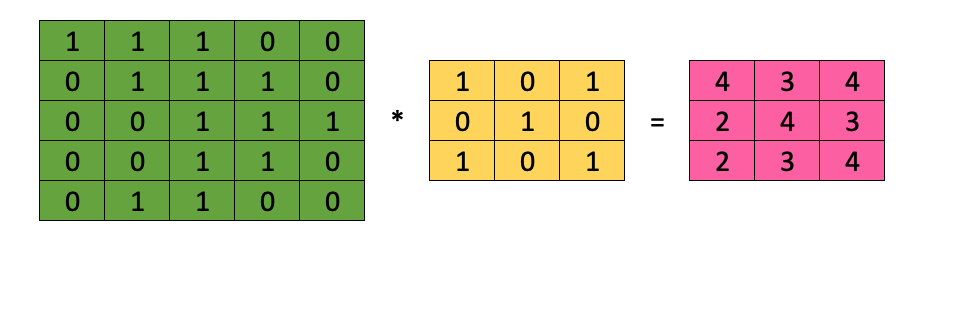


**1. Feature extraction using convolution** \\

---

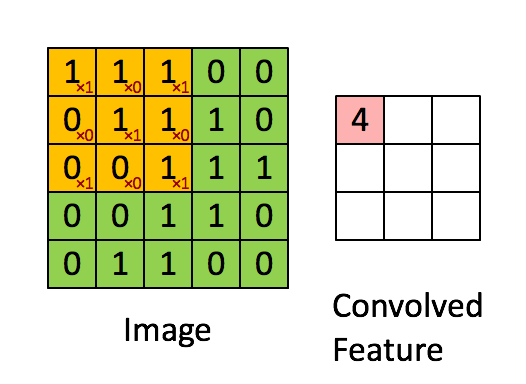

$$ output= \dfrac{W-F+2P}{S} + 1$$
where $W$ is the input size, \\
$F$ is the filter size, \\
$P$ is the padding size, \\
$W$ is the stride size. \\

**2. Pooling to reduce complexity** \\

---

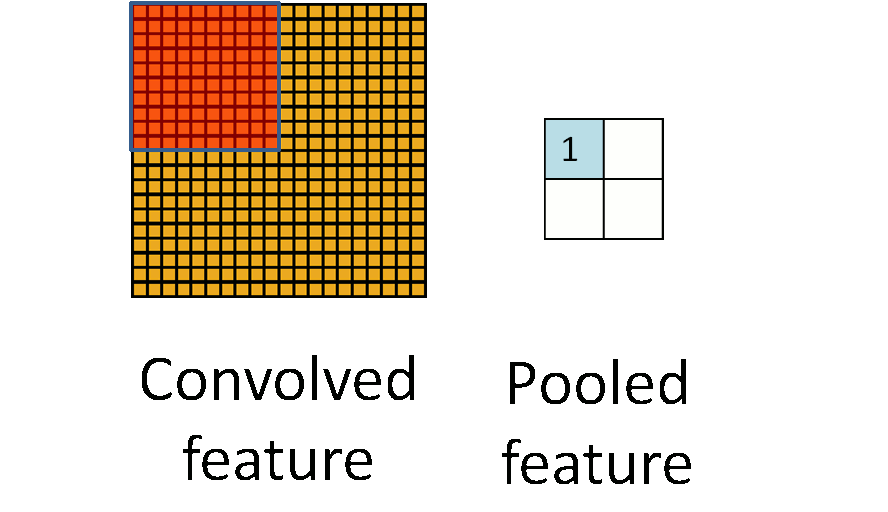

**Identification of handwritten digits (MNIST)**


---



In [ ]:
import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from matplotlib import pyplot
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D, Dropout, MaxPooling2D, Activation, ZeroPadding2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Loading the mnist images
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

print(train_images.shape) # (60000, 28, 28)
print(train_labels.shape) # (60000,)
print(test_images.shape) # (10000, 28, 28)
print(test_labels.shape) # (10000,)

In [ ]:
# Visualizing the MNIST images
sample_img_idx = np.random.randint(0, train_images.shape[0]+1, 9)
plt.figure(figsize=(10,10))
for i, j in enumerate(sample_img_idx):
    image, label = train_images[j], train_labels[j]
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image, cmap=pyplot.get_cmap('gray'))
    plt.title(label)
    plt.axis('off')

In [ ]:
# Normalizing and reshaping the data**
#First, we normalize the image pixel values from [0, 255] to [-0.5, 0.5].
#Second, we reshape the images from (28, 28) to (28, 28, 1) to add the third dimension required by Keras

# Normalize the images
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

print(train_images.shape) # (60000, 28, 28, 1)
print(test_images.shape)  # (10000, 28, 28, 1)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
print(train_labels.shape) # (60000, 10)
print(test_labels.shape)  # (10000, 10)

**Building the model**
1.   Main operations: Convolution, Pooling, and activation (prediction)

  Pooling: Average pooling was often used historically but has recently fallen out of favor compared to the max pooling operation, which has been shown to work better in practice.


cnn-dims-3.svg

In [ ]:
## parameters that reflect the figure just above
num_filters = 8
pool_size   = 2
num_classes = 10

## other important model parameters
filter_size = 3
strides     = 1
padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down.
                      # When padding="same" and strides=1, the output has the same size as the input

## parameters related to input samples
batch_size  = 64
input_shape = (train_images.shape[1:]) # (28, 28, 1)

## construct model
model = Sequential()
model.add(Conv2D(filters = 1 * num_filters,
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # Sequential model needs the input shape

model.add(MaxPooling2D(pool_size=pool_size)) # Keras automatically infers the shapes of inputs of later layers

#model.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
#model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

#model.add(Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
model.add(Flatten()) # Flatten serves as a connection between the convolution and dense layers
model.add(Dense(num_classes, activation='softmax')) # output layer

# Different syntax, different padding
model_2 = Sequential([
  Conv2D(filters = 1 * num_filters, kernel_size = filter_size, input_shape=(28, 28, 1), padding='same', activation='relu'),
  MaxPooling2D(pool_size=pool_size),
  #Conv2D(8 * num_filters, kernel_size=(filter_size, filter_size), activation='relu'),
  #MaxPooling2D(pool_size=(pool_size, pool_size)),
  #Dropout(0.25),
  Flatten(),
  Dense(num_classes, activation='softmax'),
])

In [ ]:
# Summary of the model
model.summary()

In [ ]:
model_2.summary()

In [ ]:
# Plot model
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)


In [ ]:
# Compile the model
model.compile(
  'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

In [ ]:
# Train the mdoel
# https://keras.io/api/callbacks/

epochs = 3

# Saving the model during training to be used later
checkpoint = ModelCheckpoint("mnist_best_model.hdf5",  # saving the best model
                            monitor='val_loss', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


In [ ]:
# Fitting the model
history = model.fit(
  train_images,
  train_labels,
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(test_images, test_labels), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings
)

In [ ]:
# availale keys in history
print(history.history.keys())

In [ ]:
# plot training history
plt.figure(figsize=(8,4))

# History for accuracy
plt.subplot(121)
plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(epochs))
plt.legend(['train', 'test'])

# History for loss
plt.subplot(122)
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(epochs))
plt.legend(['train', 'test'])

plt.tight_layout()
plt.show()

In [ ]:
# Define confusion matrix
def calc_error(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1

    return error, confusions

In [ ]:
# Model predictions and confusion matrix
test_predictions          = np.argmax(model.predict(test_images),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(test_labels,1))
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.title('Confusion matrix for MNIST digit classifier')
plt.xlabel('Actual digit')
plt.ylabel('Predicted digit')
plt.grid(False)
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

# A brief note on Optimization
For the interest of time, we will not explore different optimization strategies in depth. Note however that we implemented standard Stochastic Gradient Descent for our MLP model, whereas we used the Adam optimizer for our Keras-based CNN model. Feel free to explore different optimizers and other (hyper)parameters that might affect optimization (e.g. batch size).